In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



import community as community_louvain
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

from scipy.spatial import ConvexHull

from collections import Counter
import os

import copy
import random

c:\Users\daneb\Desktop\Egyetem\KozTechHalok\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
OUT = "outputs"
SUBFOLDERS = [
    "graph_stats",
    "centrality",
    "communities",
    "gnn",
    "embedding_graph",
    "gcn_vs_louvain"
]
for sub in SUBFOLDERS:
    os.makedirs(os.path.join(OUT, sub), exist_ok=True)


In [3]:
def save_plot(path):
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"[Saved] {path}")

def save_csv(path, data_dict):
    df = pd.DataFrame([data_dict])
    df.to_csv(path, index=False)
    print(f"[Saved] {path}")


In [4]:
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

G = to_networkx(data, to_undirected=True)
G = nx.convert_node_labels_to_integers(G)


In [5]:
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

degrees = np.array([d for _, d in G.degree()])
avg_deg = degrees.mean()
density = nx.density(G)
avg_clustering = nx.average_clustering(G)
num_cc = nx.number_connected_components(G)

plt.figure(figsize=(6,4))
sns.histplot(degrees, bins=30)
plt.title("Degree distribution (Cora)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xlim(1, 30)
save_plot(f"{OUT}/graph_stats/degree_distribution.png")

components = sorted(nx.connected_components(G), key=len, reverse=True)
giant = G.subgraph(components[0]).copy()
diameter = nx.diameter(giant)
avg_shortest = nx.average_shortest_path_length(giant)

save_csv(f"{OUT}/graph_stats/graph_basic_stats.csv", {
    "n_nodes": n_nodes,
    "n_edges": n_edges,
    "avg_degree": avg_deg,
    "density": density,
    "avg_clustering": avg_clustering,
    "connected_components": num_cc,
    "giant_component_size": giant.number_of_nodes(),
    "diameter": diameter,
    "avg_shortest_path": avg_shortest
})


[Saved] outputs/graph_stats/degree_distribution.png
[Saved] outputs/graph_stats/graph_basic_stats.csv


In [6]:
labels = data.y.cpu().numpy()

def neighbor_homophily(G, labels):
    hom = []
    for u in G.nodes():
        neigh = list(G.neighbors(u))
        if len(neigh)==0:
            hom.append(np.nan)
            continue
        same = sum(labels[v]==labels[u] for v in neigh)
        hom.append(same/len(neigh))
    return np.array(hom)

homophily = neighbor_homophily(G, labels)

plt.figure(figsize=(6,4))
sns.histplot(homophily[~np.isnan(homophily)], bins=20)
plt.title("Neighbor homophily")
plt.xlabel("Homophily")
save_plot(f"{OUT}/graph_stats/homophily.png")

save_csv(f"{OUT}/graph_stats/homophily_stats.csv", {
    "median_homophily": np.nanmedian(homophily)
})


[Saved] outputs/graph_stats/homophily.png
[Saved] outputs/graph_stats/homophily_stats.csv


In [7]:
deg_cent = dict(G.degree())
pagerank = nx.pagerank(G)
eigen_cent = nx.eigenvector_centrality(G, max_iter=500, tol=1e-06)
betw = nx.betweenness_centrality(G, k=200)

triangles = nx.triangles(G)
avg_triangles = np.mean(list(triangles.values()))
core_numbers = nx.core_number(G)
max_core = max(core_numbers.values())

save_csv(f"{OUT}/centrality/centrality_stats.csv", {
    "avg_triangles": avg_triangles,
    "max_core": max_core
})

deg = np.array([deg_cent[i] for i in G.nodes()])
bet = np.array([betw[i] for i in G.nodes()])
pr = np.array([pagerank[i] for i in G.nodes()])

roles = {}
for n in G.nodes():
    if deg_cent[n] > np.percentile(deg, 95):
        roles[n] = "Hub"
    elif betw[n] > np.percentile(bet, 95):
        roles[n] = "Bridge"
    elif pr[n] < np.percentile(pr, 10):
        roles[n] = "Peripheral"
    else:
        roles[n] = "Normal"

save_csv(f"{OUT}/centrality/roles.csv", roles)


role_list = list(roles.values())
unique_roles, counts = np.unique(role_list, return_counts=True)

plt.figure(figsize=(8, 5))
sns.barplot(x=unique_roles, y=counts, palette="tab10")
plt.title("Role Distribution (Hub / Bridge / Peripheral / Normal)")
plt.ylabel("Number of Nodes")
plt.xlabel("Role")

save_plot(f"{OUT}/centrality/role_distribution.png")


[Saved] outputs/centrality/centrality_stats.csv
[Saved] outputs/centrality/roles.csv
[Saved] outputs/centrality/role_distribution.png


C:\Users\daneb\AppData\Local\Temp\ipykernel_11856\950085819.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_roles, y=counts, palette="tab10")


In [9]:
partition = community_louvain.best_partition(G)
communities = np.array([partition[i] for i in range(n_nodes)])
num_comms = len(set(communities))
modularity = community_louvain.modularity(partition, G)

nmi = normalized_mutual_info_score(labels, communities)
ari = adjusted_rand_score(labels, communities)

save_csv(f"{OUT}/communities/louvain_metrics.csv", {
    "num_communities": num_comms,
    "modularity": modularity,
    "NMI_comm_vs_labels": nmi,
    "ARI_comm_vs_labels": ari
})

pos = nx.spring_layout(G, seed=42, k=0.1)

plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
nx.draw(G, pos, node_color=labels, node_size=20, cmap='tab10', width=0.3)
plt.title("Labels")

plt.subplot(1,2,2)
nx.draw(G, pos, node_color=communities, node_size=20, cmap='tab20', width=0.3)
plt.title("Louvain Communities")

save_plot(f"{OUT}/communities/labels_vs_communities.png")


[Saved] outputs/communities/louvain_metrics.csv
[Saved] outputs/communities/labels_vs_communities.png


In [10]:

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        return self.conv2(x, edge_index)

model = GCN(dataset.num_features, 64, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

embeddings_over_time = []

for epoch in range(1,201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        embeddings_over_time.append(out.detach().cpu().numpy())

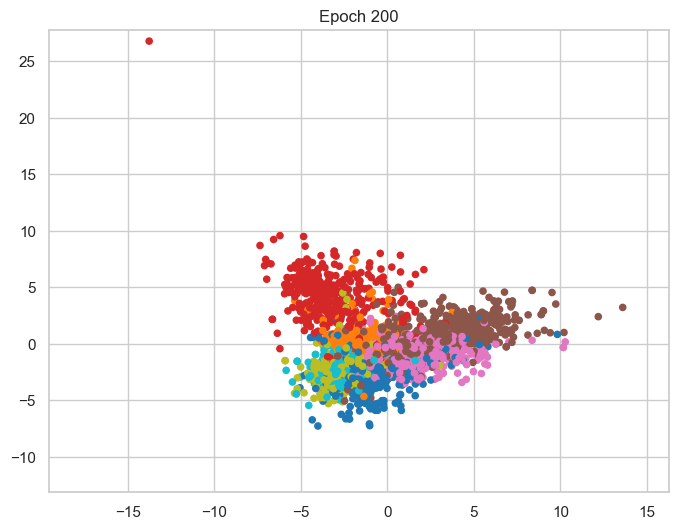

In [11]:
proj_over_time = [PCA(n_components=2).fit_transform(emb) for emb in embeddings_over_time]

fig, ax = plt.subplots(figsize=(8,6))
colors = labels
sc = ax.scatter(proj_over_time[0][:,0], proj_over_time[0][:,1], c=colors, cmap="tab10", s=20)

all_points = np.vstack(proj_over_time)
ax.set_xlim(np.min(all_points[:,0]) - 1, np.max(all_points[:,0]) + 1)
ax.set_ylim(np.min(all_points[:,1]) - 1, np.max(all_points[:,1]) + 1)

def update(frame):
    sc.set_offsets(proj_over_time[frame])
    ax.set_title(f"Epoch {(frame+1)*10}")
    return sc,

ani = FuncAnimation(fig, update, frames=len(proj_over_time), interval=500, blit=True)
ani.save(f"{OUT}/gnn/embedding_evolution.gif", writer="pillow", fps=2)


In [12]:
proj = proj_over_time[-1]
clf = LogisticRegression(max_iter=500).fit(proj[data.train_mask], data.y[data.train_mask])

xx, yy = np.meshgrid(
    np.linspace(proj[:,0].min()-1, proj[:,0].max()+1, 400),
    np.linspace(proj[:,1].min()-1, proj[:,1].max()+1, 400)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(grid).reshape(xx.shape)

plt.figure(figsize=(10,7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
plt.scatter(proj[:,0], proj[:,1], c=labels, s=8, cmap="tab10")
plt.title("Decision Boundary")
save_plot(f"{OUT}/gnn/decision_boundary.png")

[Saved] outputs/gnn/decision_boundary.png


In [13]:
def plot_hull(proj, labels, epoch):
    clf = LogisticRegression(max_iter=500).fit(proj, labels)

    xx, yy = np.meshgrid(
        np.linspace(proj[:,0].min()-1, proj[:,0].max()+1, 400),
        np.linspace(proj[:,1].min()-1, proj[:,1].max()+1, 400)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.2, cmap="tab10")
    plt.scatter(proj[:,0], proj[:,1], c=labels, s=10, cmap="tab10")

    for lbl in np.unique(labels):
        pts = proj[labels == lbl]
        if len(pts) >= 3:
            hull = ConvexHull(pts)
            hull_pts = pts[hull.vertices]
            plt.plot(hull_pts[:,0], hull_pts[:,1], linewidth=1)

    plt.title(f"Epoch {epoch}")

for idx, proj in enumerate([proj_over_time[0], proj_over_time[5], proj_over_time[-1]]):
    epoch = (idx+1)*10
    plot_hull(proj, labels, epoch)
    save_plot(f"{OUT}/gnn/hull_epoch_{epoch}.png")

[Saved] outputs/gnn/hull_epoch_10.png
[Saved] outputs/gnn/hull_epoch_20.png
[Saved] outputs/gnn/hull_epoch_30.png


In [14]:
orig_proj = PCA(n_components=2).fit_transform(data.x.numpy())

def plot_hull_only(proj, labels, name):
    plt.figure(figsize=(6,5))
    plt.scatter(proj[:,0], proj[:,1], c=labels, s=8, cmap="tab10")
    for lbl in np.unique(labels):
        pts = proj[labels==lbl]
        if len(pts)>=3:
            hull = ConvexHull(pts)
            hull_pts = pts[hull.vertices]
            plt.plot(hull_pts[:,0], hull_pts[:,1])
    save_plot(f"{OUT}/gnn/{name}.png")

plot_hull_only(orig_proj, labels, "original_feature_hulls")
plot_hull_only(proj_over_time[-1], labels, "gnn_embedding_hulls")


[Saved] outputs/gnn/original_feature_hulls.png
[Saved] outputs/gnn/gnn_embedding_hulls.png


In [15]:
final_emb = embeddings_over_time[-1]
nbrs = NearestNeighbors(n_neighbors=6).fit(final_emb)
distances, indices = nbrs.kneighbors(final_emb)

G_emb = nx.Graph()
G_emb.add_nodes_from(range(n_nodes))
for i in range(n_nodes):
    for j in indices[i][1:]:
        G_emb.add_edge(i, j)

deg_cent_emb = dict(G_emb.degree())
clust_emb = nx.average_clustering(G_emb)
deg_cent_orig = dict(G.degree())
clust_orig = nx.average_clustering(G)

partition_emb = community_louvain.best_partition(G_emb)
communities_emb = np.array([partition_emb[i] for i in range(n_nodes)])

partition_orig = community_louvain.best_partition(G)
communities_orig = np.array([partition_orig[i] for i in range(n_nodes)])

nmi_emb_labels = normalized_mutual_info_score(communities_emb, labels)
ari_emb_labels = adjusted_rand_score(communities_emb, labels)

save_csv(f"{OUT}/embedding_graph/embedding_graph_metrics.csv", {
    "avg_degree_emb": np.mean(list(deg_cent_emb.values())),
    "clustering_emb": clust_emb,
    "avg_degree_orig": np.mean(list(deg_cent_orig.values())),
    "clustering_orig": clust_orig,
    "NMI_emb_vs_labels": nmi_emb_labels,
    "ARI_emb_vs_labels": ari_emb_labels
})


[Saved] outputs/embedding_graph/embedding_graph_metrics.csv


In [16]:
def plot_eg(G_emb, colors, name):
    plt.figure(figsize=(20,12))
    pos = {i: final_emb[i,:2] for i in range(n_nodes)}
    nx.draw(G_emb, pos, node_color=colors, cmap="tab10", node_size=40, alpha=0.9, width=0.05)
    save_plot(f"{OUT}/embedding_graph/{name}.png")

plot_eg(G_emb, communities_orig, "knn_orig_comms")
plot_eg(G_emb, communities_emb, "knn_emb_comms")
plot_eg(G_emb, labels, "knn_labels")

switch_nodes = np.where(communities_emb != communities_orig)[0]
colors = np.array(['grey']*n_nodes)
colors[switch_nodes] = 'red'
plot_eg(G_emb, colors, "knn_switch_nodes")

[Saved] outputs/embedding_graph/knn_orig_comms.png
[Saved] outputs/embedding_graph/knn_emb_comms.png
[Saved] outputs/embedding_graph/knn_labels.png


c:\Users\daneb\Desktop\Egyetem\KozTechHalok\.venv\Lib\site-packages\networkx\drawing\nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


[Saved] outputs/embedding_graph/knn_switch_nodes.png


In [17]:
def compute_cluster_metrics(emb, labels):
    unique = np.unique(labels)
    centroids = {}
    intra = []
    for u in unique:
        pts = emb[labels==u]
        c = pts.mean(axis=0)
        centroids[u] = c
        intra.append(np.linalg.norm(pts - c, axis=1).mean())
    inter = []
    keys = list(centroids.keys())
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            inter.append(np.linalg.norm(centroids[keys[i]] - centroids[keys[j]]))
    return np.mean(intra), np.mean(inter)

intra_list = []
inter_list = []
for proj in proj_over_time:
    intra, inter = compute_cluster_metrics(proj, labels)
    intra_list.append(intra)
    inter_list.append(inter)

epochs = np.arange(1, len(proj_over_time)+1)*10

plt.figure(figsize=(7,5))
plt.plot(epochs, intra_list, label="Intra")
plt.plot(epochs, inter_list, label="Inter")
plt.legend()
save_plot(f"{OUT}/gnn/intra_inter.png")

df = pd.DataFrame({
    "epoch": epochs,
    "intra": intra_list,
    "inter": inter_list,
    "ratio": np.array(inter_list)/np.array(intra_list)
})
df.to_csv(f"{OUT}/gnn/cluster_metrics.csv", index=False)

[Saved] outputs/gnn/intra_inter.png


In [18]:
model = GCN(dataset.num_features, 64, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred_labels = model(data.x, data.edge_index).argmax(dim=1).cpu().numpy()

nmi_pred_comm = normalized_mutual_info_score(pred_labels, communities_orig)
ari_pred_comm = adjusted_rand_score(pred_labels, communities_orig)

nmi_pred_labels = normalized_mutual_info_score(pred_labels, labels)
ari_pred_labels = adjusted_rand_score(pred_labels, labels)

save_csv(f"{OUT}/gcn_vs_louvain/gcn_vs_communities.csv", {
    "NMI_pred_vs_comm": nmi_pred_comm,
    "ARI_pred_vs_comm": ari_pred_comm,
    "NMI_pred_vs_labels": nmi_pred_labels,
    "ARI_pred_vs_labels": ari_pred_labels
})

[Saved] outputs/gcn_vs_louvain/gcn_vs_communities.csv


In [20]:
SIM_OUT = f"{OUT}/simulations/edge_dropout"
os.makedirs(SIM_OUT, exist_ok=True)

dropout_rates = [0.0, 0.1, 0.2, 0.4, 0.6]

results = []

In [ ]:
def drop_edges(G, drop_rate):
    G_new = G.copy()
    edges = list(G_new.edges())
    n_drop = int(len(edges) * drop_rate)
    drop_edges = random.sample(edges, n_drop)
    G_new.remove_edges_from(drop_edges)
    return G_new

In [22]:
def gcn_predict_on_modified_graph(G_mod):
    edge_index_new = torch.tensor(list(G_mod.edges())).t().contiguous()
    if edge_index_new.numel() == 0:
        return None
    logits = model(data.x, edge_index_new)
    return logits.argmax(dim=1).cpu().numpy()


In [ ]:
for rate in dropout_rates:
    print(f"\n--- Edge Dropout {int(rate*100)}% ---")
    
    G_corrupt = drop_edges(G, rate)
    
    try:
        partition_corrupt = community_louvain.best_partition(G_corrupt)
        comm_corrupt = np.array([partition_corrupt[i] for i in range(n_nodes)])
    except:
        comm_corrupt = np.zeros(n_nodes)
    
    nmi_louvain = normalized_mutual_info_score(labels, comm_corrupt)
    ari_louvain = adjusted_rand_score(labels, comm_corrupt)

    pred_corrupt = gcn_predict_on_modified_graph(G_corrupt)

    if pred_corrupt is None:
        gcn_nmi = 0
        gcn_ari = 0
    else:
        gcn_nmi = normalized_mutual_info_score(labels, pred_corrupt)
        gcn_ari = adjusted_rand_score(labels, pred_corrupt)

    results.append({
        "dropout_rate": rate,
        "NMI_louvain_vs_labels": nmi_louvain,
        "ARI_louvain_vs_labels": ari_louvain,
        "NMI_gcn_vs_labels": gcn_nmi,
        "ARI_gcn_vs_labels": gcn_ari,
    })


--- Edge Dropout 0% ---

--- Edge Dropout 10% ---

--- Edge Dropout 20% ---

--- Edge Dropout 40% ---

--- Edge Dropout 60% ---


In [24]:
df_results = pd.DataFrame(results)
df_results.to_csv(f"{SIM_OUT}/edge_dropout_results.csv", index=False)
print(f"[Saved] {SIM_OUT}/edge_dropout_results.csv")


[Saved] outputs/simulations/edge_dropout/edge_dropout_results.csv


In [25]:
plt.figure(figsize=(10,6))
plt.plot(dropout_rates, df_results["NMI_louvain_vs_labels"], marker="o", label="Louvain NMI")
plt.plot(dropout_rates, df_results["NMI_gcn_vs_labels"], marker="o", label="GCN NMI")
plt.xlabel("Edge Dropout Rate")
plt.ylabel("NMI (vs True Labels)")
plt.title("Edge Dropout Robustness: Louvain vs GCN")
plt.legend()
save_plot(f"{SIM_OUT}/nmi_plot.png")

plt.figure(figsize=(10,6))
plt.plot(dropout_rates, df_results["ARI_louvain_vs_labels"], marker="o", label="Louvain ARI")
plt.plot(dropout_rates, df_results["ARI_gcn_vs_labels"], marker="o", label="GCN ARI")
plt.xlabel("Edge Dropout Rate")
plt.ylabel("ARI (vs True Labels)")
plt.title("Edge Dropout Robustness: Louvain vs GCN")
plt.legend()
save_plot(f"{SIM_OUT}/ari_plot.png")


[Saved] outputs/simulations/edge_dropout/nmi_plot.png
[Saved] outputs/simulations/edge_dropout/ari_plot.png


In [26]:
SIM_FN = f"{OUT}/simulations/feature_noise"
os.makedirs(SIM_FN, exist_ok=True)

noise_levels = [0.0, 0.05, 0.1, 0.2, 0.5]

results_fn = []

In [27]:
partition_orig = community_louvain.best_partition(G)
comm_orig = np.array([partition_orig[i] for i in range(n_nodes)])
nmi_louvain_labels = normalized_mutual_info_score(labels, comm_orig)
ari_louvain_labels = adjusted_rand_score(labels, comm_orig)

print(f"Louvain (no feature noise) NMI={nmi_louvain_labels:.3f}, ARI={ari_louvain_labels:.3f}")


Louvain (no feature noise) NMI=0.453, ARI=0.226


In [28]:
for sigma in noise_levels:
    print(f"\n--- Feature Noise σ={sigma} ---")
    
    if sigma == 0.0:
        noisy_x = data.x.clone()
    else:
        noise = torch.randn_like(data.x) * sigma
        noisy_x = data.x + noise

    model.eval()
    with torch.no_grad():
        logits = model(noisy_x, data.edge_index)
        pred_noisy = logits.argmax(dim=1).cpu().numpy()

    nmi_gcn = normalized_mutual_info_score(labels, pred_noisy)
    ari_gcn = adjusted_rand_score(labels, pred_noisy)

    results_fn.append({
        "sigma": sigma,
        "NMI_gcn_vs_labels": nmi_gcn,
        "ARI_gcn_vs_labels": ari_gcn,
        "NMI_louvain_vs_labels": nmi_louvain_labels,
        "ARI_louvain_vs_labels": ari_louvain_labels
    })

df_fn = pd.DataFrame(results_fn)
df_fn.to_csv(f"{SIM_FN}/feature_noise_results.csv", index=False)
print(f"[Saved] {SIM_FN}/feature_noise_results.csv")

plt.figure(figsize=(10,6))
plt.plot(df_fn["sigma"], df_fn["NMI_gcn_vs_labels"], marker="o", label="GCN NMI")
plt.hlines(nmi_louvain_labels, xmin=min(noise_levels), xmax=max(noise_levels),
           linestyles="dashed", label="Louvain NMI (topology only)")
plt.xlabel("Feature Noise σ")
plt.ylabel("NMI vs True Labels")
plt.title("Feature Noise Robustness: GCN vs Louvain")
plt.legend()
save_plot(f"{SIM_FN}/nmi_feature_noise.png")

plt.figure(figsize=(10,6))
plt.plot(df_fn["sigma"], df_fn["ARI_gcn_vs_labels"], marker="o", label="GCN ARI")
plt.hlines(ari_louvain_labels, xmin=min(noise_levels), xmax=max(noise_levels),
           linestyles="dashed", label="Louvain ARI (topology only)")
plt.xlabel("Feature Noise σ")
plt.ylabel("ARI vs True Labels")
plt.title("Feature Noise Robustness: GCN vs Louvain")
plt.legend()
save_plot(f"{SIM_FN}/ari_feature_noise.png")



--- Feature Noise σ=0.0 ---

--- Feature Noise σ=0.05 ---

--- Feature Noise σ=0.1 ---

--- Feature Noise σ=0.2 ---

--- Feature Noise σ=0.5 ---
[Saved] outputs/simulations/feature_noise/feature_noise_results.csv
[Saved] outputs/simulations/feature_noise/nmi_feature_noise.png
[Saved] outputs/simulations/feature_noise/ari_feature_noise.png


In [29]:
SIM_RW = f"{OUT}/simulations/graph_rewire"
os.makedirs(SIM_RW, exist_ok=True)

rewire_probs = [0.0, 0.1, 0.2, 0.4, 0.6]

results_rw = []


In [30]:
def rewire_graph(G_in, p):
    G_mod = G_in.copy()
    edges = list(G_mod.edges())
    nodes = list(G_mod.nodes())
    n_edges = len(edges)

    for (u, v) in edges:
        if np.random.rand() < p:
            if not G_mod.has_edge(u, v):
                continue
            G_mod.remove_edge(u, v)
            tries = 0
            while True:
                w = np.random.choice(nodes)
                if w != u and not G_mod.has_edge(u, w):
                    G_mod.add_edge(u, w)
                    break
                tries += 1
                if tries > 10:
                    break
    return G_mod

In [31]:
def gcn_predict_on_graph(G_mod):
    edges = list(G_mod.edges())
    if len(edges) == 0:
        return None
    edge_index_new = torch.tensor(edges, dtype=torch.long).t().contiguous()
    model.eval()
    with torch.no_grad():
        logits = model(data.x, edge_index_new)
    return logits.argmax(dim=1).cpu().numpy()

In [ ]:
for p in rewire_probs:
    print(f"\n--- Graph Rewiring p={p} ---")
    G_rw = rewire_graph(G, p)

    try:
        part_rw = community_louvain.best_partition(G_rw)
        comm_rw = np.array([part_rw[i] for i in range(n_nodes)])
    except:
        comm_rw = np.zeros(n_nodes)

    nmi_louvain = normalized_mutual_info_score(labels, comm_rw)
    ari_louvain = adjusted_rand_score(labels, comm_rw)

    pred_rw = gcn_predict_on_graph(G_rw)
    if pred_rw is None:
        nmi_gcn = 0.0
        ari_gcn = 0.0
    else:
        nmi_gcn = normalized_mutual_info_score(labels, pred_rw)
        ari_gcn = adjusted_rand_score(labels, pred_rw)

    results_rw.append({
        "rewire_prob": p,
        "NMI_louvain_vs_labels": nmi_louvain,
        "ARI_louvain_vs_labels": ari_louvain,
        "NMI_gcn_vs_labels": nmi_gcn,
        "ARI_gcn_vs_labels": ari_gcn
    })



--- Graph Rewiring p=0.0 ---

--- Graph Rewiring p=0.1 ---

--- Graph Rewiring p=0.2 ---

--- Graph Rewiring p=0.4 ---

--- Graph Rewiring p=0.6 ---


In [33]:
df_rw = pd.DataFrame(results_rw)
df_rw.to_csv(f"{SIM_RW}/graph_rewire_results.csv", index=False)
print(f"[Saved] {SIM_RW}/graph_rewire_results.csv")

plt.figure(figsize=(10,6))
plt.plot(df_rw["rewire_prob"], df_rw["NMI_louvain_vs_labels"], marker="o", label="Louvain NMI")
plt.plot(df_rw["rewire_prob"], df_rw["NMI_gcn_vs_labels"], marker="o", label="GCN NMI")
plt.xlabel("Rewiring probability")
plt.ylabel("NMI vs True Labels")
plt.title("Graph Rewiring Robustness: Louvain vs GCN")
plt.legend()
save_plot(f"{SIM_RW}/nmi_rewire.png")

plt.figure(figsize=(10,6))
plt.plot(df_rw["rewire_prob"], df_rw["ARI_louvain_vs_labels"], marker="o", label="Louvain ARI")
plt.plot(df_rw["rewire_prob"], df_rw["ARI_gcn_vs_labels"], marker="o", label="GCN ARI")
plt.xlabel("Rewiring probability")
plt.ylabel("ARI vs True Labels")
plt.title("Graph Rewiring Robustness: Louvain vs GCN")
plt.legend()
save_plot(f"{SIM_RW}/ari_rewire.png")



[Saved] outputs/simulations/graph_rewire/graph_rewire_results.csv
[Saved] outputs/simulations/graph_rewire/nmi_rewire.png
[Saved] outputs/simulations/graph_rewire/ari_rewire.png


In [34]:
SIM_TA = f"{OUT}/simulations/targeted_attacks"
os.makedirs(SIM_TA, exist_ok=True)

attack_fractions = [0.01, 0.03, 0.05]

results_ta = []

deg_cent_all = dict(G.degree())
bet_cent_all = betw


In [35]:
def remove_node_edges(G_in, target_nodes):
    G_mod = G_in.copy()
    for u in target_nodes:
        G_mod.remove_edges_from(list(G_mod.edges(u)))
    return G_mod

def gcn_predict_on_graph_simple(G_mod):
    edges = list(G_mod.edges())
    if len(edges) == 0:
        return None
    edge_index_new = torch.tensor(edges, dtype=torch.long).t().contiguous()
    model.eval()
    with torch.no_grad():
        logits = model(data.x, edge_index_new)
    return logits.argmax(dim=1).cpu().numpy()

nodes_sorted_by_deg = sorted(deg_cent_all.items(), key=lambda x: -x[1])
nodes_sorted_by_bet = sorted(bet_cent_all.items(), key=lambda x: -x[1])

In [ ]:
for frac in attack_fractions:
    k = max(1, int(frac * n_nodes))
    top_deg_nodes = [n for n,_ in nodes_sorted_by_deg[:k]]
    top_bet_nodes = [n for n,_ in nodes_sorted_by_bet[:k]]

    G_hub = remove_node_edges(G, top_deg_nodes)

    try:
        part_hub = community_louvain.best_partition(G_hub)
        comm_hub = np.array([part_hub[i] for i in range(n_nodes)])
    except:
        comm_hub = np.zeros(n_nodes)
    nmi_louvain_hub = normalized_mutual_info_score(labels, comm_hub)
    ari_louvain_hub = adjusted_rand_score(labels, comm_hub)

    pred_hub = gcn_predict_on_graph_simple(G_hub)
    if pred_hub is None:
        nmi_gcn_hub = 0.0
        ari_gcn_hub = 0.0
    else:
        nmi_gcn_hub = normalized_mutual_info_score(labels, pred_hub)
        ari_gcn_hub = adjusted_rand_score(labels, pred_hub)

    G_bet = remove_node_edges(G, top_bet_nodes)

    try:
        part_bet = community_louvain.best_partition(G_bet)
        comm_bet = np.array([part_bet[i] for i in range(n_nodes)])
    except:
        comm_bet = np.zeros(n_nodes)
    nmi_louvain_bet = normalized_mutual_info_score(labels, comm_bet)
    ari_louvain_bet = adjusted_rand_score(labels, comm_bet)

    pred_bet = gcn_predict_on_graph_simple(G_bet)
    if pred_bet is None:
        nmi_gcn_bet = 0.0
        ari_gcn_bet = 0.0
    else:
        nmi_gcn_bet = normalized_mutual_info_score(labels, pred_bet)
        ari_gcn_bet = adjusted_rand_score(labels, pred_bet)

    results_ta.append({
        "attack_fraction": frac,
        "k_nodes": k,

        "NMI_louvain_hub_vs_labels": nmi_louvain_hub,
        "ARI_louvain_hub_vs_labels": ari_louvain_hub,
        "NMI_gcn_hub_vs_labels": nmi_gcn_hub,
        "ARI_gcn_hub_vs_labels": ari_gcn_hub,

        "NMI_louvain_bet_vs_labels": nmi_louvain_bet,
        "ARI_louvain_bet_vs_labels": ari_louvain_bet,
        "NMI_gcn_bet_vs_labels": nmi_gcn_bet,
        "ARI_gcn_bet_vs_labels": ari_gcn_bet,
    })

df_ta = pd.DataFrame(results_ta)
df_ta.to_csv(f"{SIM_TA}/targeted_attacks_results.csv", index=False)
print(f"[Saved] {SIM_TA}/targeted_attacks_results.csv")

plt.figure(figsize=(10,6))
plt.plot(df_ta["attack_fraction"], df_ta["NMI_louvain_hub_vs_labels"], marker="o", label="Louvain Hub NMI")
plt.plot(df_ta["attack_fraction"], df_ta["NMI_gcn_hub_vs_labels"], marker="o", label="GCN Hub NMI")
plt.plot(df_ta["attack_fraction"], df_ta["NMI_louvain_bet_vs_labels"], marker="o", linestyle="--", label="Louvain Betweenness NMI")
plt.plot(df_ta["attack_fraction"], df_ta["NMI_gcn_bet_vs_labels"], marker="o", linestyle="--", label="GCN Betweenness NMI")
plt.xlabel("Attack Fraction (top-k nodes)")
plt.ylabel("NMI vs True Labels")
plt.title("Targeted Attacks: Hubs & Betweenness")
plt.legend()
save_plot(f"{SIM_TA}/nmi_targeted_attacks.png")

plt.figure(figsize=(10,6))
plt.plot(df_ta["attack_fraction"], df_ta["ARI_louvain_hub_vs_labels"], marker="o", label="Louvain Hub ARI")
plt.plot(df_ta["attack_fraction"], df_ta["ARI_gcn_hub_vs_labels"], marker="o", label="GCN Hub ARI")
plt.plot(df_ta["attack_fraction"], df_ta["ARI_louvain_bet_vs_labels"], marker="o", linestyle="--", label="Louvain Betweenness ARI")
plt.plot(df_ta["attack_fraction"], df_ta["ARI_gcn_bet_vs_labels"], marker="o", linestyle="--", label="GCN Betweenness ARI")
plt.xlabel("Attack Fraction (top-k nodes)")
plt.ylabel("ARI vs True Labels")
plt.title("Targeted Attacks: Hubs & Betweenness")
plt.legend()
save_plot(f"{SIM_TA}/ari_targeted_attacks.png")


[Saved] outputs/simulations/targeted_attacks/targeted_attacks_results.csv
[Saved] outputs/simulations/targeted_attacks/nmi_targeted_attacks.png
[Saved] outputs/simulations/targeted_attacks/ari_targeted_attacks.png
